#### ANL Sprint 2017

HSC-DR1 LSS Sprint:
Addressing the first task here:
https://github.com/LSSTDESC/HyperSupremeStructure-HSC-LSS/blob/master/SprintWeekDiary.md, that is comparingg Depth (limiting magnitude) from three methods:
1. Using Javi's method
2. Binning 5*flux_error for all galaxies in each pixel.
3. Using the random sky_std as described in https://hsc-release.mtk.nao.ac.jp/doc/index.php/random-points-for-dr1/. 

For each of these, we have the mean depth and depth variance for each of the five bands.

#### Here: calculate the twoPt corr from the three methods to see how they compare.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
import os
from astropy.io import fits

from astropy.table import Table
import healpy as hp
from collections import OrderedDict
from matplotlib import cm
import copy

from dataCleanUp import dataCleanUp
from addSNR import addSNR
from createMaps import createMeanStdMaps
from mpl_toolkits.axes_grid1 import ImageGrid
from twoPtCorr import runTreeCorr
from plots import plot_wtheta
import flatmaps as fm

Read in the data. Reading the latest ones: now have the random Table for the wide GAMA15H field.

In [2]:
HSCdatapath= '/global/cscratch1/sd/damonge/HSC/'
HSCFiles= os.listdir(HSCdatapath)
HSCFiles= ['HSC_WIDE_GAMA15H_forced.fits', 'HSC_WIDE_GAMA15H_random.fits']

In [3]:
HSCFiles= [HSCdatapath+f for f in HSCFiles]
HSCFiles

['/global/cscratch1/sd/damonge/HSC/HSC_WIDE_GAMA15H_forced.fits',
 '/global/cscratch1/sd/damonge/HSC/HSC_WIDE_GAMA15H_random.fits']

In [4]:
HSCdata= {}
for filename in HSCFiles:
    key= filename.split('WIDE_')[1].split('.fits')[0]
    dat = Table.read(filename, format='fits')
    HSCdata[key] = dat.to_pandas()
    
HSCFieldTag= key.split('_')[0]  # just the field tag.

In [5]:
# clean up
for key in HSCdata:
    print key
    HSCdata[key]= dataCleanUp(HSCdata[key])

GAMA15H_random
Given size of the dataframe:  (8121501, 60)
Dropped 30 isnull columns.
Dropped 8121471 rows since they contained nan entries.
idetect_is_primary in dataframe, so dropping objects with idetect_is_primary= False.
Dropped 2022870 rows based on idetect_is_primary= False.
Final size of the dataframe:  (6098631, 29)

GAMA15H_forced
Given size of the dataframe:  (7681225, 196)
Dropped 98 isnull columns.
Dropped 7681127 rows since they contained nan entries.
Final size of the dataframe:  (6139128, 98)



#### Read in the depth maps. Saved from the other notebook (HSC_5sigma-depth.ipynb).

In [6]:
outputDir= 'maps/'
depthFiles= os.listdir(outputDir)
depthFiles= [f for f in depthFiles if not f.__contains__('std')] # ignore the std across the maps for now
depthFiles= [f for f in depthFiles if not f.__contains__('RandomSkyStdMethod.npz')] # ignore ~isPrimary maps

In [7]:
depthMap= {}

for filename in depthFiles:
    splits= filename.split('-band_')
    band= splits[0][-1:]
    method= splits[1].split('Method')[0]
    
    if method not in depthMap.keys(): depthMap[method]= {}   
    depthMap[method][band]= fm.read_flat_map(outputDir+filename)[1]

In [8]:
bands= ['g', 'r', 'i', 'z', 'y']
flatSkyGrid= fm.FlatMapInfo([212.5,222.],[-2.,2.], dx=0.057,dy=0.057)

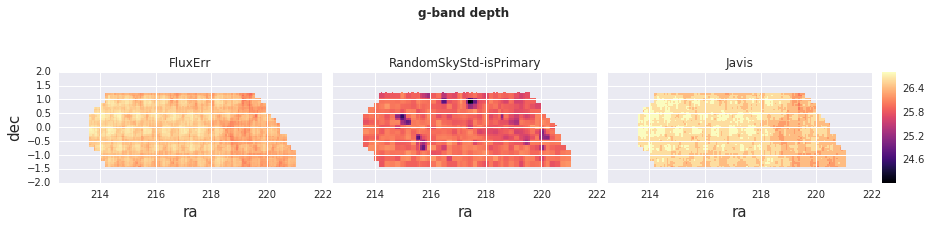

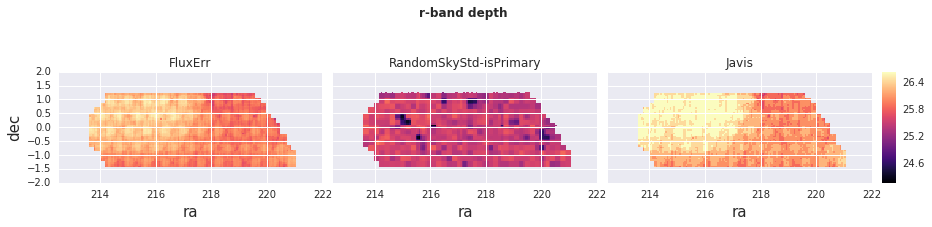

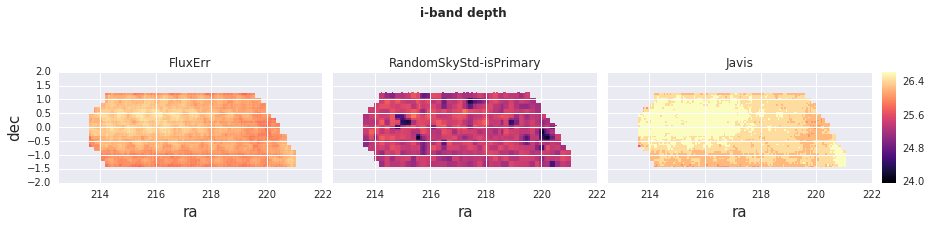

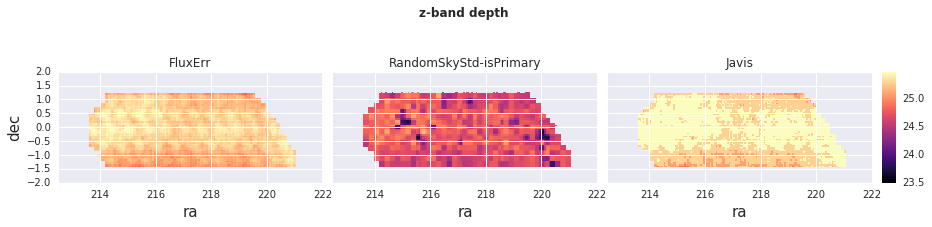

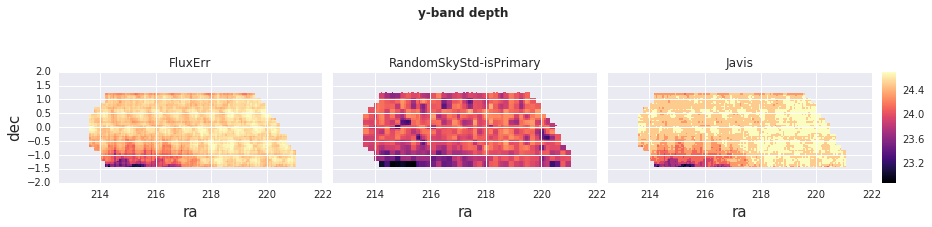

In [9]:
# just plot to see everything is ok
cmap = cm.magma
xlabel, ylabel= 'ra', 'dec'
for band in bands:
    # plot the depth for each method.
    fig = plt.figure(figsize=(15, 10))
    # set up for colorbar
    grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                     nrows_ncols=(1,3), axes_pad=0.15, share_all= True, cbar_location="right",
                     cbar_mode="single", cbar_size="5%", cbar_pad=0.15,
                     )
    # since have three maps, need colorange that ~works for all.
    colorMin= 100
    colorMax= -100
    for mInd, method in enumerate(depthMap):
        ind= np.where(depthMap[method][band]>0)[0]
        colorMin= min(colorMin, np.percentile(depthMap[method][band][ind], 0))
        colorMax= max(colorMin, np.percentile(depthMap[method][band][ind], 95))
    # plot
    for mInd, method in enumerate(depthMap):
        ax= grid[mInd]
        image= ax.imshow(depthMap[method][band].reshape([flatSkyGrid.ny,flatSkyGrid.nx]),
                         origin='lower', interpolation='nearest',
                         aspect='equal', extent=[flatSkyGrid.x0, flatSkyGrid.xf, flatSkyGrid.y0, flatSkyGrid.yf],
                         vmin= colorMin, vmax= colorMax, cmap= cmap)
        ax.set_title(method)
        ax.set_xlabel(xlabel,fontsize=15)
        ax.set_ylabel(ylabel,fontsize=15)
        ax.cax.colorbar(image)
        ax.cax.toggle_label(True)
    plt.suptitle('%s-band depth'%band, fontweight="bold", )
    plt.subplots_adjust(top=1.5)
    plt.show()
   

#### Now need to find the limiting mags for each depth map. Consider i-band as the detection band.

In [10]:
HSCFieldTag= 'GAMA15H_forced'
band= 'i'

In [11]:
pixelNums= flatSkyGrid.pos2pix(HSCdata[HSCFieldTag]['ra'], HSCdata[HSCFieldTag]['dec'])

In [12]:
# find five sigma depth for each object. add columns to dataframe.
fiveSigCols= {}
for method in depthMap:
    fiveSigCols[method]= []
    print method
    for band in bands:
        key= '%s-%s-5sigmaDepth'%(method, band)
        fiveSigCols[method].append(key)
        HSCdata[HSCFieldTag][key]= depthMap[method][band][pixelNums]
    
    print 'Added cols:\n%s\n'%fiveSigCols[method]

FluxErr
Added cols:
['FluxErr-g-5sigmaDepth', 'FluxErr-r-5sigmaDepth', 'FluxErr-i-5sigmaDepth', 'FluxErr-z-5sigmaDepth', 'FluxErr-y-5sigmaDepth']

RandomSkyStd-isPrimary
Added cols:
['RandomSkyStd-isPrimary-g-5sigmaDepth', 'RandomSkyStd-isPrimary-r-5sigmaDepth', 'RandomSkyStd-isPrimary-i-5sigmaDepth', 'RandomSkyStd-isPrimary-z-5sigmaDepth', 'RandomSkyStd-isPrimary-y-5sigmaDepth']

Javis
Added cols:
['Javis-g-5sigmaDepth', 'Javis-r-5sigmaDepth', 'Javis-i-5sigmaDepth', 'Javis-z-5sigmaDepth', 'Javis-y-5sigmaDepth']



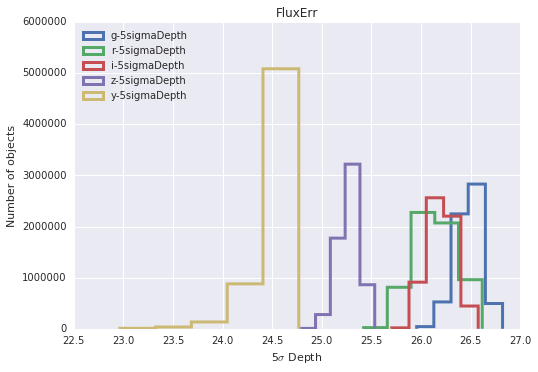

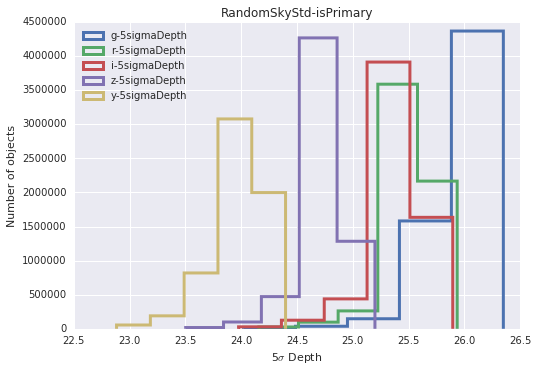

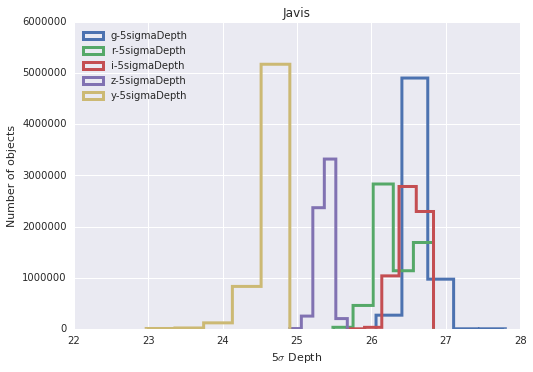

In [13]:
# plot histogram: number of objects we have for different depth bins
for method in depthMap:
    fig, ax = plt.subplots()
    for key in fiveSigCols[method]:
        plt.hist(HSCdata[HSCFieldTag][key], label= key.split(method+'-')[1], histtype= 'step', alpha= 1., lw= 3, bins= 5)
    ax.legend(loc= "upper left")
    ax.set_xlabel('5$\sigma$ Depth')
    ax.set_ylabel('Number of objects')
    ax.set_title(method)
    plt.show()

Ok so distribution from random-skyStd differ quite a bit from the other two methods.

In [14]:
band = 'i'

In [15]:
def stats(arr, returnData= False): # quick function to print/return stats on an array (min, max rn.)
    print 'Min: %s, Max: %s'%(min(arr), max(arr))
    if returnData: return min(arr), max(arr)

/global/common/cori/software/python/2.7-anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:5907: UserWarning: 2D hist input should be nsamples x nvariables;
 this looks transposed (shape is 0 x 1)
  '(shape is %d x %d)' % inp.shape[::-1])


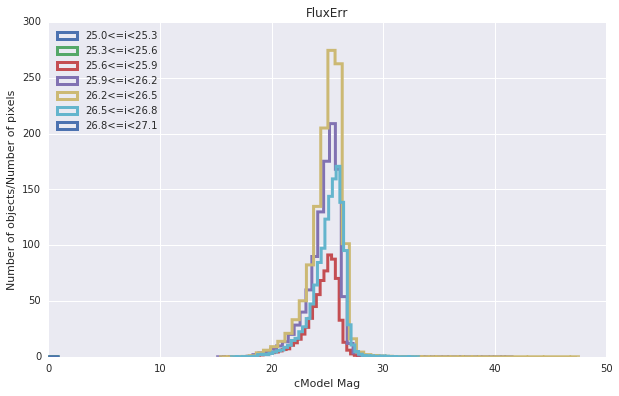

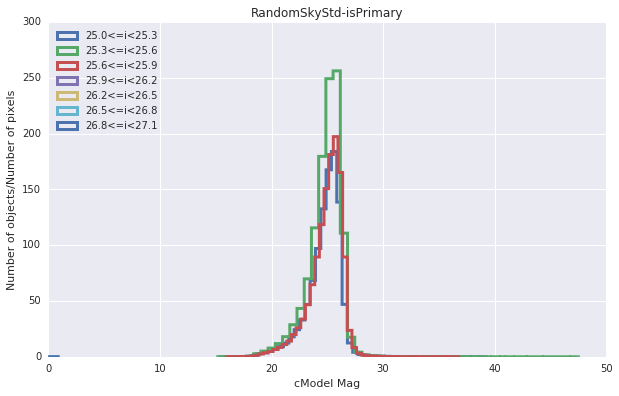

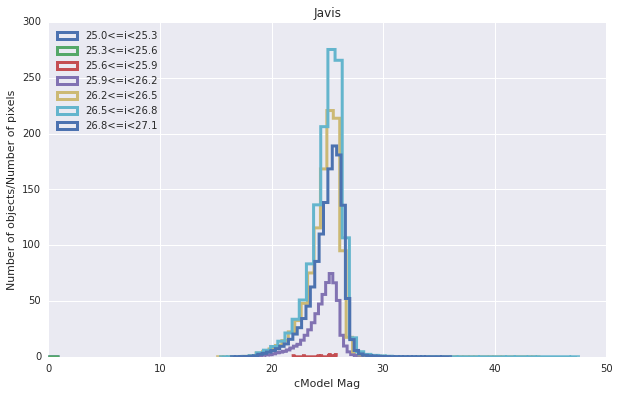

In [16]:
# plot object density as a function of 5sigma depth
densityTrend= OrderedDict()
for method in depthMap:
    densityTrend[method]= {}
    fiveSigmaKey= '%s-%s-5sigmaDepth'%(method, band)
    # find the min, max on the depth to decide on the bin ends.
    #minDepth, maxDepth= stats(HSCdata[HSCFieldTag][fiveSigmaKey], returnData= True)
    #minDepth, maxDepth= np.floor(minDepth), np.ceil(maxDepth)
    step= 0.3
    depthBins= np.arange(25, 27+step, step) #np.arange(minDepth, maxDepth+step, step)
    
    # plot/store 
    plt.clf()
    fig, ax = plt.subplots()
    for i in range(len(depthBins)):
        if (i>0):
            magCutTag= '%s<=%s<%s'%(depthBins[i-1], band, depthBins[i])
            # find indices where 5sigma depth is within the depth range.
            fiveSigmaArr= np.array(HSCdata[HSCFieldTag][fiveSigmaKey])
            magCutInd= np.where((fiveSigmaArr>= depthBins[i-1]) & (fiveSigmaArr< depthBins[i]))[0]
            
            # histrogram the objects' mags that satisfy the 5sigma depth cut.
            # weight by the number of pixels.
            magArr= np.array(HSCdata[HSCFieldTag]['%scmodel_mag'%band])
            weight= np.ones(len(magCutInd))/np.count_nonzero((depthMap[method][band]>=depthBins[i-1])&(depthMap[method][band]<depthBins[i]))
            densityTrend[method][magCutTag]= plt.hist(magArr[magCutInd], weights= weight,
                                              label= magCutTag, histtype= 'step', alpha= 1., lw= 3, bins= 50)
    ax.legend(loc= 'upper left')
    ax.set_xlabel('cModel Mag')
    ax.set_ylabel('Number of objects/Number of pixels')
    ax.set_title(method)
    #ax.set_xlim(0, maxDepth+5*step)
    plt.gcf().set_size_inches(10,6)
    plt.show()

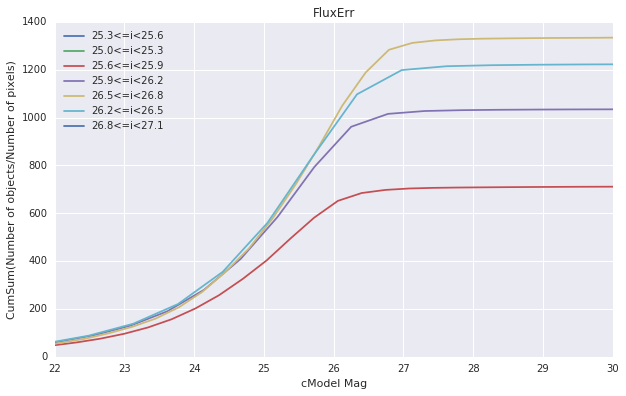

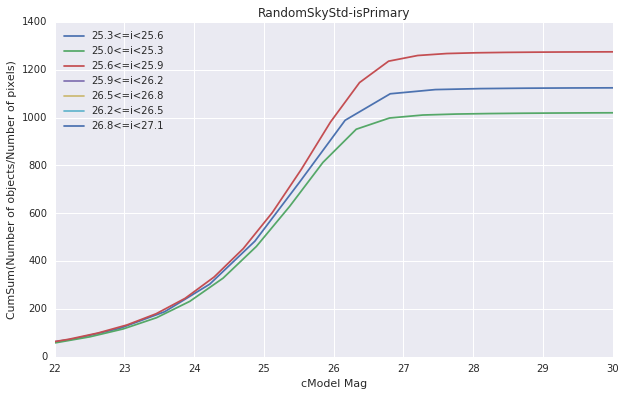

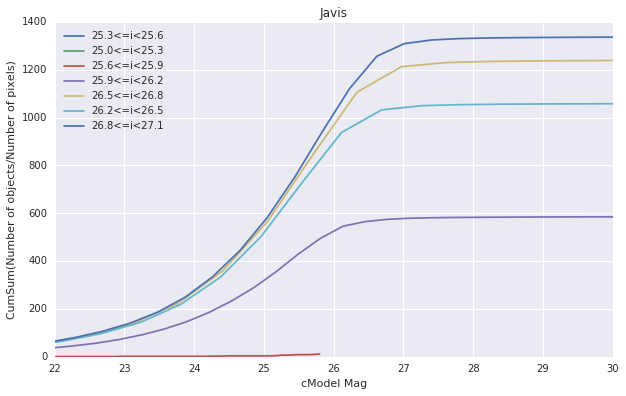

In [17]:
# try to look at the plot above another way?
for method in depthMap:
    for cut in densityTrend[method].keys():    
        plt.plot(densityTrend[method][cut][1][1:], np.cumsum(densityTrend[method][cut][0]), label= cut)
    plt.legend(loc= 'upper left')
    plt.xlabel('cModel Mag')
    plt.ylabel('CumSum(Number of objects/Number of pixels)')
    plt.title(method)
    plt.gcf().set_size_inches(10,6)
    plt.xlim(22,30)
    plt.show()
    

In [18]:
limitingMag= {'Javis': 26.0, 'RandomSkyStd-isPrimary': 25.0, 'FluxErr': 25.8}

#### Set up to run twoPt corr.

In [19]:
HSCFieldTag= 'GAMA15H_forced'

FluxErr
4122910 galaxies to consider.


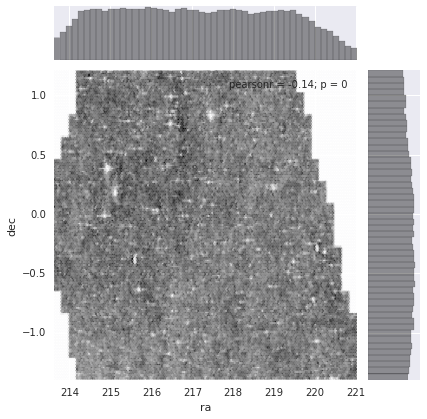

RandomSkyStd-isPrimary
2535506 galaxies to consider.


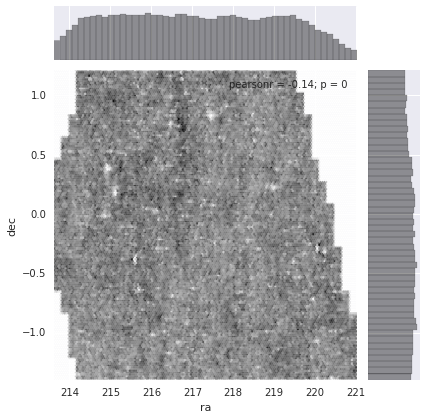

Javis
4465256 galaxies to consider.


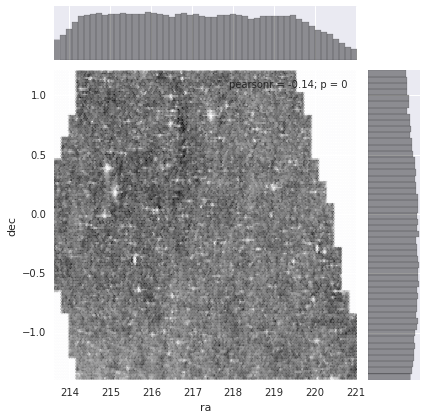

In [20]:
# find the mag-limited galaxy sample
galSample_ra, galSample_dec= {}, {}

for method in limitingMag:
    print method
    ind= np.where((HSCdata[HSCFieldTag]['%scmodel_mag'%band]<limitingMag[method]) & 
              (HSCdata[HSCFieldTag]['iclassification_extendedness']==1))[0]

    galSample_ra[method], galSample_dec[method]= HSCdata[HSCFieldTag]['ra'].iloc[ind], HSCdata[HSCFieldTag]['dec'].iloc[ind]
    print '%s galaxies to consider.'%len(galSample_ra[method])
    
    plt.clf()
    sns.jointplot(x=galSample_ra[method], y= galSample_dec[method], kind="hex", color="k")
    plt.show()

#### Random depth maps + random catalogs.

First create random-depth map: anything with i>limiting mag gets depth= 1. else depth= 0. go from HP pixels to ra, dec for random ra, dec catalog.

Then create a uniform array in ra, sin(dec). Covert to pixel numbers, see which pixels fall in survey, and keep only the ra, decs that correspond to the 'good' pixels.

Then keep only the ra, dec from the uniform array that correspond to the pixels with depth= 1. in the random depth map.

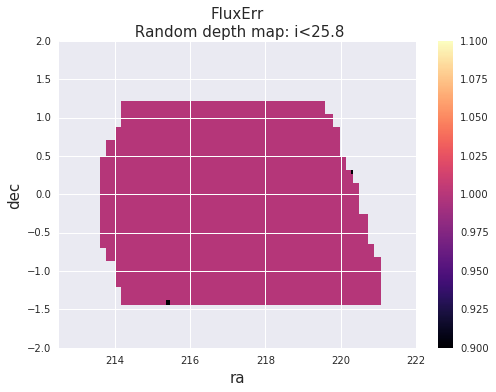

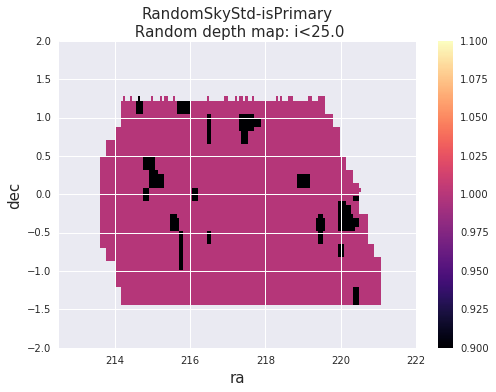

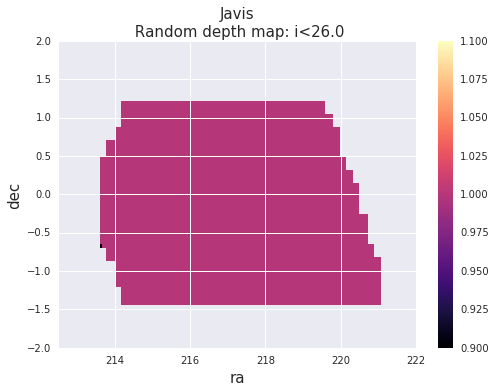

In [21]:
# random depth maps
randomDepth= {}
for method in depthMap.keys():
    ind= np.where(depthMap[method][band]> limitingMag[method])[0]
    randomDepth[method]= copy.deepcopy(depthMap[method][band])
    randomDepth[method][~np.isnan(depthMap[method][band])]= 0.  # keep the mask
    randomDepth[method][ind]= 1.
    flatSkyGrid.view_map(randomDepth[method], 
                         posColorbar= True, title= "%s\n Random depth map: %s<%s"%(method, 
                                                                                  band, limitingMag[method]),
                         xlabel='ra', ylabel='dec')

Number of random objects:  8930512


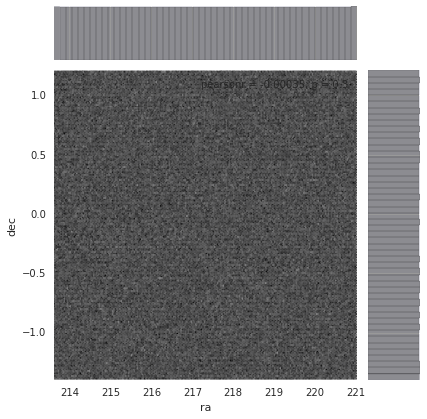

In [22]:
# uniform random catalog. no geometry yet.
rand= pd.DataFrame()
nData= 0
for method in depthMap:
    nData= max(nData, len(galSample_ra[method]))
rand['ra'] = np.rad2deg(np.random.uniform(np.deg2rad(min(HSCdata[HSCFieldTag]['ra'])),
                               np.deg2rad(max(HSCdata[HSCFieldTag]['ra'])), nData*2))
rand['sinDec']= np.random.uniform(np.sin(np.deg2rad(min(HSCdata[HSCFieldTag]['dec']))),
                                  np.sin(np.deg2rad(max(HSCdata[HSCFieldTag]['dec']))), nData*2)
rand['dec'] = np.rad2deg(np.arcsin(rand['sinDec']))

print 'Number of random objects: ', len(rand)

sns.jointplot(x=rand['ra'], y=rand['dec'], kind="hex", color="k")

FluxErr
Dropped 950507 rows from the original sq. array.


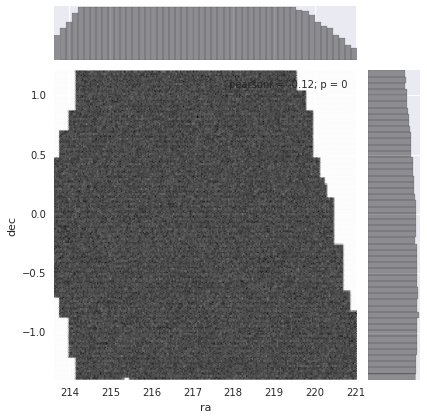

RandomSkyStd-isPrimary
Dropped 1383975 rows from the original sq. array.


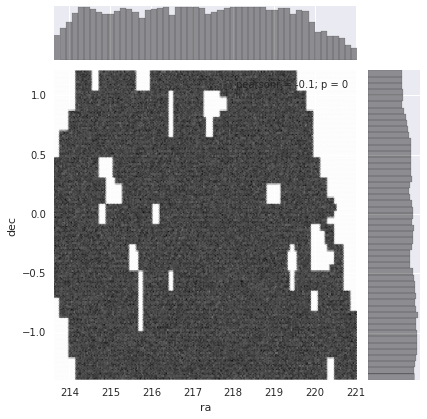

Javis
Dropped 948767 rows from the original sq. array.


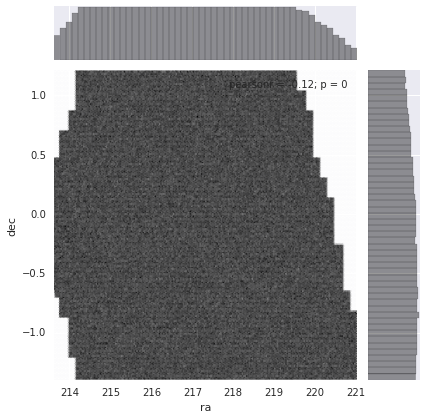

In [23]:
# create random catalog with geometry: find pixels coresponding to the random ra, dec. keep only those that
# have depth= 1 in the depth map.
randCatalog= {}
for method in randomDepth:
    print method
    # find pixel numbers corresponding to the ra, decs.
    pixelNums= flatSkyGrid.pos2pix(rand['ra'], rand['dec'])
    # find pixel numbers in survey
    pixelNumsInSurvey= np.where(randomDepth[method]>0)[0]

    # find out whether the random-pixelNum is in survey. mask= True <=> yes
    mask= np.in1d(pixelNums, pixelNumsInSurvey)
    badind= np.where(mask==False)[0]
    
    randCatalog[method]= rand.drop(badind, axis= 0)
    print 'Dropped %s rows from the original sq. array.'%len(badind)
    
    plt.clf()
    sns.jointplot(x=randCatalog[method]['ra'], y=randCatalog[method]['dec'], kind="hex", color="k")
    plt.show()

Ok so the random-sky-std method is really horrible. even when a shallow limiting mag cut, the randoms geometry is not uniform.

#### Run tree corr.

Running with 4122910 data pts, 7980005 random pts
Time taken: 423.094307184 (s)


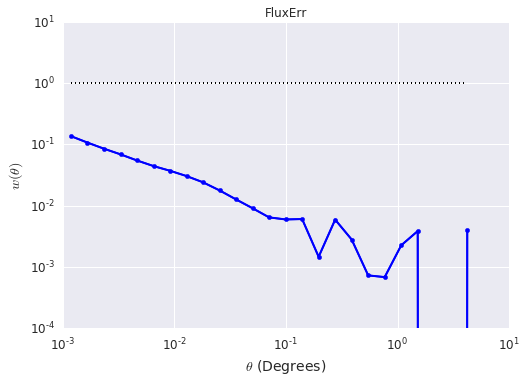

Running with 2535506 data pts, 7546537 random pts
Time taken: 320.973212004 (s)


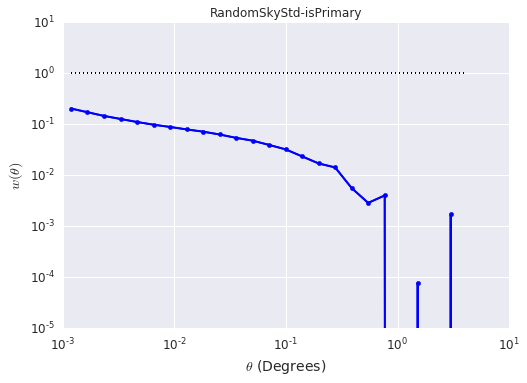

Running with 4465256 data pts, 7981745 random pts
Time taken: 430.820627928 (s)


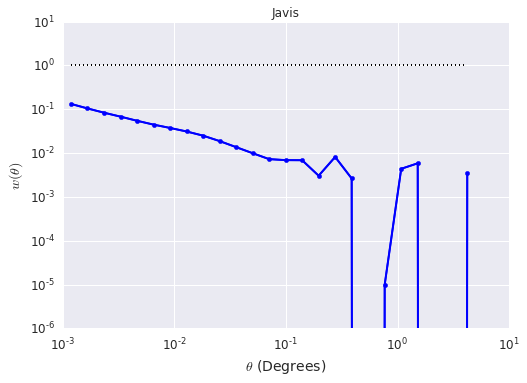

In [24]:
theta, wtheta, wtheta_sig= {}, {}, {}
for method in randomDepth:
    theta[method], wtheta[method], wtheta_sig[method]= runTreeCorr(data_ra= galSample_ra[method],
                                                       data_dec= galSample_dec[method],
                                                       random_ra= randCatalog[method]['ra'],
                                                       random_dec= randCatalog[method]['dec'],
                                                       minSep= 0.001, maxSep= 5, nBins= 25)
    
    plot_wtheta(theta[method], wtheta[method], wtheta_sig[method], title= method)

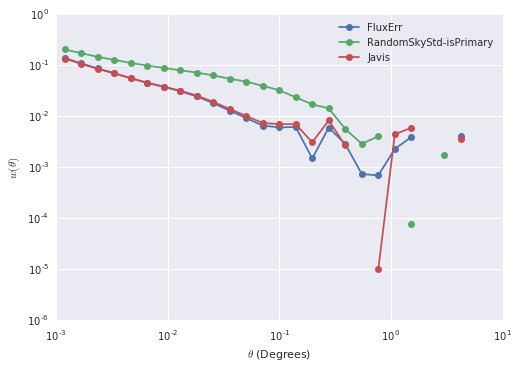

In [25]:
# over plot
for method in theta:
    plt.plot(theta[method], wtheta[method], 'o-', label= method)
plt.legend()
plt.xlabel(r'$\theta$ (Degrees)')
plt.ylabel(r'$w(\theta)$')
plt.loglog()
plt.show()

Ok great: Javi's method is comparable to flux-err method. Random-sky-std method is just not ok.